In [1]:
import os, random, numpy as np, pandas as pd
import warnings

warnings.filterwarnings("ignore")

# === Your proxy & env setup (as requested) ===
os.environ.setdefault("TOKENIZERS_PARALLELISM", "true")
os.environ["https_proxy"] = "http://10.101.159.162:7890"
os.environ["http_proxy"] = "http://10.101.159.162:7890"

# Optional: set a deterministic seed and device info
import torch
import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook", font_scale=1.1)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import evaluate  # HF metric wrapper
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    GPT2ForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [2]:
# === Paths you provided ===
import os

DATA_DIR = "../data"
RED_WINE_PATH = os.path.join(DATA_DIR, "WineQuality-RedWine.csv")
WINE2_PATH = os.path.join(DATA_DIR, "wine_dataset.csv")

# === Task selection ===
# "red_quality_binary" (default) uses WineQuality-RedWine.csv with good(>=7)/not good.
# "wine_cultivar" uses wine_dataset.csv (multiclass target).
TASK = "red_quality_binary"  # or "wine_cultivar"

# === Prompt style & model ===
TEXT_TEMPLATE = "bullet"  # "bullet" or "inline" (we'll ablate later)
MODEL_NAME = "gpt2"  # try "distilgpt2" if memory is tight
MAX_LENGTH = 256

# === Output dirs ===
OUT_DIR = "runs/gpt2_prompt_tabular"
FIG_DIR = os.path.join(OUT_DIR, "figures")
MODEL_DIR = os.path.join(OUT_DIR, "best_model")
os.makedirs(FIG_DIR, exist_ok=True)

# === Offline-friendly flags ===
# If you want *fully offline* after the first download, set:
# os.environ["TRANSFORMERS_OFFLINE"] = "1"
# And optionally pin a local cache:
# os.environ["HF_HOME"] = os.path.abspath("./.hf_cache")
# os.environ["HF_DATASETS_CACHE"] = os.path.abspath("./.hf_cache/datasets")
# os.environ["TRANSFORMERS_CACHE"]  = os.path.abspath("./.hf_cache/hub")

In [3]:
import pandas as pd

if TASK == "red_quality_binary":
    df = pd.read_csv(RED_WINE_PATH)
    assert "quality" in df.columns, "Expected 'quality' in Red Wine dataset"

    GOOD_THRESHOLD = 7
    df["label"] = (df["quality"] >= GOOD_THRESHOLD).astype(int)  # 1=good
    feature_cols = [c for c in df.columns if c not in ["quality", "label"]]
    id2label = {0: "not_good", 1: "good"}
    label2id = {v: k for k, v in id2label.items()}

elif TASK == "wine_cultivar":
    df = pd.read_csv(WINE2_PATH)
    assert "target" in df.columns, "Expected 'target' in wine_dataset.csv"

    df = df.rename(columns={"target": "label"})
    feature_cols = [c for c in df.columns if c != "label"]
    unique_labels = sorted(df["label"].unique())
    id2label = {i: str(i) for i in unique_labels}
    label2id = {v: k for k, v in id2label.items()}

else:
    raise ValueError("Unsupported TASK")

print("Task:", TASK)
print("Features:", feature_cols)
df.head()

Task: red_quality_binary
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,label
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [4]:
def serialize_row(row, feature_cols, template="bullet"):
    # Optional pretty names/units for Red Wine UCI features (fallback to column name)
    pretty = {
        "fixed acidity": ("fixed acidity", "g/dm^3"),
        "volatile acidity": ("volatile acidity", "g/dm^3"),
        "citric acid": ("citric acid", "g/dm^3"),
        "residual sugar": ("residual sugar", "g/dm^3"),
        "chlorides": ("chlorides", "g/dm^3"),
        "free sulfur dioxide": ("free sulfur dioxide", "mg/dm^3"),
        "total sulfur dioxide": ("total sulfur dioxide", "mg/dm^3"),
        "density": ("density", "g/cm^3"),
        "pH": ("pH", ""),
        "sulphates": ("sulphates", "g/dm^3"),
        "alcohol": ("alcohol", "% vol"),
    }

    def pretty_name(col):
        return pretty.get(col, (col, ""))[0]

    def unit_of(col):
        return pretty.get(col, (col, ""))[1]

    if template == "bullet":
        lines = ["The following wine has these lab measurements:"]
        for c in feature_cols:
            val = row[c]
            unit = unit_of(c)
            lines.append(f"- {pretty_name(c)}: {val} {unit}".rstrip())
        if TASK == "red_quality_binary":
            lines += [
                "",
                "Question: Is this red wine high quality (good) or not good?",
                "Answer:",
            ]
        else:
            lines += [
                "",
                "Question: Which cultivar class (0, 1, or 2) does this wine belong to?",
                "Answer:",
            ]
        return "\n".join(lines)

    else:  # inline template
        parts = []
        for c in feature_cols:
            val = row[c]
            unit = unit_of(c)
            parts.append(
                f"{pretty_name(c)} {val}{(' ' + unit) if unit else ''}".strip()
            )
        prefix = "Given a wine with "
        body = ", ".join(parts[:-1]) + (", and " + parts[-1] if parts else "")
        if TASK == "red_quality_binary":
            q = ". Is this wine high quality (good) or not good? Answer:"
        else:
            q = ". Which cultivar class (0, 1, or 2) is correct? Answer:"
        return prefix + body + q


# Shuffle for robustness and create text prompts
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
df["text"] = df.apply(lambda r: serialize_row(r, feature_cols, TEXT_TEMPLATE), axis=1)
df[["text", "label"]].head(3)

,text,label
0,The following wine has these lab measurements:...,0
1,The following wine has these lab measurements:...,0
2,The following wine has these lab measurements:...,0


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df["label"]
)
X_train, X_val = train_test_split(
    X_train, test_size=0.2, random_state=SEED, stratify=X_train["label"]
)

for name, split in [("train", X_train), ("val", X_val), ("test", X_test)]:
    print(
        name,
        split.shape,
        split["label"].value_counts(normalize=True).round(3).to_dict(),
    )

train (1023, 14) {0: 0.864, 1: 0.136}
val (256, 14) {0: 0.863, 1: 0.137}
test (320, 14) {0: 0.866, 1: 0.134}


In [6]:
from datasets import Dataset, DatasetDict


def to_hf(split_df):
    return Dataset.from_pandas(split_df[["text", "label"]].reset_index(drop=True))


raw_ds = DatasetDict(
    {
        "train": to_hf(X_train),
        "validation": to_hf(X_val),
        "test": to_hf(X_test),
    }
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# GPT-2 has no pad token by default; set pad to eos for batching
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LENGTH)


tok_ds = raw_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
tok_ds

Map:   0%|          | 0/1023 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1023
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 256
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 320
    })
})

In [7]:
from transformers import GPT2ForSequenceClassification

num_labels = len(set(df["label"]))
model = GPT2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    pad_token_id=tokenizer.pad_token_id,
    id2label=id2label,
    label2id=label2id,
).to(DEVICE)

model.config.id2label = id2label
model.config.label2id = label2id
num_labels, model.config.pad_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(2, 50256)

In [8]:
import evaluate
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    metrics = {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)[
            "accuracy"
        ],
        "f1_macro": f1_metric.compute(
            predictions=preds, references=labels, average="macro"
        )["f1"],
    }
    return metrics


training_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, TASK),
    logging_dir=os.path.join(OUT_DIR, "logs"),
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    save_total_limit=2,
    report_to="none",
    seed=SEED,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer

In [9]:
train_out = trainer.train()
train_out

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.4699555039405823, 'eval_accuracy': 0.86328125, 'eval_f1_macro': 0.46331236897274636, 'eval_runtime': 16.8331, 'eval_samples_per_second': 15.208, 'eval_steps_per_second': 0.475, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.4104994535446167, 'eval_accuracy': 0.86328125, 'eval_f1_macro': 0.46331236897274636, 'eval_runtime': 17.3992, 'eval_samples_per_second': 14.713, 'eval_steps_per_second': 0.46, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.40400049090385437, 'eval_accuracy': 0.86328125, 'eval_f1_macro': 0.46331236897274636, 'eval_runtime': 17.5313, 'eval_samples_per_second': 14.602, 'eval_steps_per_second': 0.456, 'epoch': 3.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.4057137966156006, 'eval_accuracy': 0.86328125, 'eval_f1_macro': 0.46331236897274636, 'eval_runtime': 17.0011, 'eval_samples_per_second': 15.058, 'eval_steps_per_second': 0.471, 'epoch': 4.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.4018424153327942, 'eval_accuracy': 0.86328125, 'eval_f1_macro': 0.46331236897274636, 'eval_runtime': 17.83, 'eval_samples_per_second': 14.358, 'eval_steps_per_second': 0.449, 'epoch': 5.0}
{'train_runtime': 1074.1199, 'train_samples_per_second': 4.762, 'train_steps_per_second': 0.298, 'train_loss': 0.4454977989196777, 'epoch': 5.0}


TrainOutput(global_step=320, training_loss=0.4454977989196777, metrics={'train_runtime': 1074.1199, 'train_samples_per_second': 4.762, 'train_steps_per_second': 0.298, 'total_flos': 436706994438144.0, 'train_loss': 0.4454977989196777, 'epoch': 5.0})

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.4678977131843567, 'eval_accuracy': 0.865625, 'eval_f1_macro': 0.4639865996649916, 'eval_runtime': 23.3754, 'eval_samples_per_second': 13.69, 'eval_steps_per_second': 0.428, 'epoch': 5.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy: 0.865625
Test F1-macro: 0.4639865996649916

Classification report:
               precision    recall  f1-score   support

    not_good       0.87      1.00      0.93       277
        good       0.00      0.00      0.00        43

    accuracy                           0.87       320
   macro avg       0.43      0.50      0.46       320
weighted avg       0.75      0.87      0.80       320



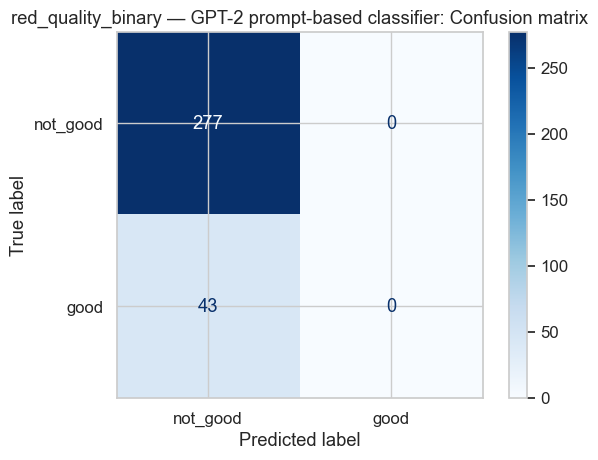

In [10]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

test_metrics = trainer.evaluate(eval_dataset=tok_ds["test"])
print(test_metrics)

preds = trainer.predict(tok_ds["test"])
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("Test F1-macro:", f1_score(y_true, y_pred, average="macro"))
print(
    "\nClassification report:\n",
    classification_report(
        y_true, y_pred, target_names=[id2label[i] for i in sorted(id2label)]
    ),
)

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[id2label[i] for i in sorted(id2label)]).plot(
    cmap="Blues"
)
plt.title(f"{TASK} — GPT-2 prompt-based classifier: Confusion matrix")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, f"{TASK}_cm.png"), dpi=140)
plt.show()

In [11]:
alt_template = "inline" if TEXT_TEMPLATE == "bullet" else "bullet"

df_alt = df.copy()
df_alt["text"] = df_alt.apply(
    lambda r: serialize_row(r, feature_cols, alt_template), axis=1
)

Xa_train, Xa_test = train_test_split(
    df_alt, test_size=0.2, random_state=SEED, stratify=df_alt["label"]
)
Xa_train, Xa_val = train_test_split(
    Xa_train, test_size=0.2, random_state=SEED, stratify=Xa_train["label"]
)

from datasets import DatasetDict

alt_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(
            Xa_train[["text", "label"]].reset_index(drop=True)
        ),
        "validation": Dataset.from_pandas(
            Xa_val[["text", "label"]].reset_index(drop=True)
        ),
        "test": Dataset.from_pandas(Xa_test[["text", "label"]].reset_index(drop=True)),
    }
).map(
    lambda b: tokenizer(b["text"], truncation=True, max_length=MAX_LENGTH),
    batched=True,
    remove_columns=["text"],
)

from transformers import GPT2ForSequenceClassification, TrainingArguments, Trainer

alt_model = GPT2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    pad_token_id=tokenizer.pad_token_id,
    id2label=id2label,
    label2id=label2id,
).to(DEVICE)

alt_trainer = Trainer(
    model=alt_model,
    args=TrainingArguments(
        output_dir=os.path.join(OUT_DIR, f"{TASK}_ablate_{alt_template}"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        learning_rate=5e-5,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        save_total_limit=2,
        report_to="none",
        seed=SEED,
    ),
    train_dataset=alt_ds["train"],
    eval_dataset=alt_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

alt_trainer.train()
alt_pred = alt_trainer.predict(alt_ds["test"])
from sklearn.metrics import f1_score

print(
    f"Ablation ({alt_template}) Test F1-macro:",
    f1_score(alt_pred.label_ids, alt_pred.predictions.argmax(-1), average="macro"),
)

Map:   0%|          | 0/1023 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.4910554587841034, 'eval_accuracy': 0.86328125, 'eval_f1_macro': 0.46331236897274636, 'eval_runtime': 11.6099, 'eval_samples_per_second': 22.05, 'eval_steps_per_second': 0.689, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.4129667282104492, 'eval_accuracy': 0.86328125, 'eval_f1_macro': 0.46331236897274636, 'eval_runtime': 11.5642, 'eval_samples_per_second': 22.137, 'eval_steps_per_second': 0.692, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.4013028144836426, 'eval_accuracy': 0.86328125, 'eval_f1_macro': 0.46331236897274636, 'eval_runtime': 11.9175, 'eval_samples_per_second': 21.481, 'eval_steps_per_second': 0.671, 'epoch': 3.0}
{'train_runtime': 923.6358, 'train_samples_per_second': 3.323, 'train_steps_per_second': 0.208, 'train_loss': 0.5838889280954996, 'epoch': 3.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Ablation (inline) Test F1-macro: 0.4639865996649916


In [12]:
import json, pandas as pd, os

os.makedirs(MODEL_DIR, exist_ok=True)

trainer.save_model(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)

pd.DataFrame([test_metrics]).to_csv(
    os.path.join(OUT_DIR, f"{TASK}_test_metrics.csv"), index=False
)
with open(os.path.join(OUT_DIR, f"{TASK}_config.json"), "w") as f:
    json.dump(
        {
            "task": TASK,
            "model": MODEL_NAME,
            "template": TEXT_TEMPLATE,
            "max_length": MAX_LENGTH,
            "seed": SEED,
        },
        f,
        indent=2,
    )

print("Saved model & artifacts to:", MODEL_DIR)

Saved model & artifacts to: runs/gpt2_prompt_tabular\best_model


In [13]:
## done